In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import pandas as pd
import os
import seaborn as sns
from skimage import transform, io
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout,Activation,Flatten, AvgPool2D

In [2]:
x_train_dir = './data/train_x.npy'
# x_label_dir = './data/train_y.npy'

X_train = np.load(x_train_dir, allow_pickle=True)
# X_label = np.load(x_label_dir, allow_pickle=True)

In [3]:
x_label_dir = './data/new_labels.csv'
X_label = pd.read_csv(x_label_dir).values
X_label = X_label[:,1:]
print(X_label)

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [139]:
words_dir = 'D:\\GIT\\Dian\\labels\\words'
words = pd.read_csv(words_dir, header=None)

In [140]:
print(words)

            0
0        city
1    mountain
2         sky
3         sun
4       water
..        ...
369      maui
370    school
371     canoe
372      race
373    hawaii

[374 rows x 1 columns]


## Loss

In [98]:
def myLoss(y_true, y_pred):
#     print(tf.reduce_mean(y_pred))
    y_true = tf.cast(y_true, dtype = tf.float32)
    return tf.nn.sigmoid_cross_entropy_with_logits(labels = y_true, logits=y_pred)

In [36]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

## Accuracy

In [15]:
class Myaccuracy(tf.keras.metrics.Metric):
    def __init__(self):
        super().__init__()
#         self.tp = self.add_weight(name = 'tp', dtype = tf.int32, initializer=tf.zeros_initializer)
#         self.fp = self.add_weight(name = 'fp', dtype = tf.int32, initializer=tf.zeros_initializer)
#         self.fn = self.add_weight(name = 'fn', dtype = tf.int32, initializer=tf.zeros_initializer)
        self.f1 = self.add_weight(name = 'f1', dtype = tf.float32, initializer=tf.zeros_initializer())
    def update_state(self, y_true, y_pred):
        thresh = 0.5
        y_pred = tf.cast(tf.greater(y_pred, thresh), tf.float32)
        self.tp = tf.cast(tf.math.count_nonzero(y_pred * y_true), axis = 0, dtype=tf.float32)
        self.fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y_true), axis=0), tf.float32)
        self.fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y_true, axis=0), tf.float32)
        self.f1.assign_add(2*self.tp / (2*self.tp + self.fn + self.fp + 1e-16))
    def result(self):
        return self.f1

In [27]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y = tf.cast(y, dtype=tf.float32)
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [215]:
@tf.function
def test_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y = tf.cast(y, dtype=tf.float32)
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    macro_f1 = tf.reduce_mean(tp)
    return macro_f1

### Add Layer

In [182]:
class addLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.units = units
    def build(self, input_shape):
        self.w1 = self.add_weight(name = 'w1', shape = [input_shape[-1], self.units], initializer=tf.random_normal_initializer(mean = 0.2))
        self.w2 = self.add_weight(name = 'w2', shape = [input_shape[-1], self.units], initializer=tf.random_normal_initializer(mean = 0.8))
    def call(self, input1, input2):
        y_pred = tf.matmul(input1, self.w1) + tf.matmul(input2, self.w2)
        return y_pred
        

In [22]:
tf.config.experimental_run_functions_eagerly(True)

In [224]:
class Conv(Model):
    def __init__(self):
        super(Conv, self).__init__()
#         self.p1 = AvgPool2D(pool_size=4, strides=4)
#         self.flatten1 = Flatten()
#         self.d3 = Dense(512, activation = 'tanh', kernel_initializer=tf.keras.initializers.RandomNormal(mean = 0.05))
        
        self.c1 = Conv2D(filters = 6, kernel_size=3, strides=1, padding='same',)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.c2 = Conv2D(filters = 12, kernel_size=3, strides=1, padding='same')
        self.b2 = BatchNormalization()
        self.a2 = Activation('tanh')
        self.p3 = MaxPool2D(pool_size=(4, 4), strides=4, padding='valid')
        self.flatten2 = Flatten()
        self.d1 = Dense(512, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean = 0.00, stddev = 0.01))
#         self.d2 = Dense(344, activation='sigmoid')
        self.d2 = Dense(344, kernel_initializer=tf.keras.initializers.RandomNormal(mean = 0.0))
        
#         self.addlayer = addLayer(512)
    @tf.function
    def call(self, x):
#         x1 = self.p1(x)
#         x1 = self.flatten1(x1)
#         x1 = self.d3(x1)
        
        x2 = self.c1(x)
        x2 = self.b1(x2)
        x2 = self.a1(x2)
        
        x2 = self.c2(x2)
        x2 = self.b2(x2)
        x2 = self.a2(x2)
        
        x2 = self.p3(x2)
        x2 = self.flatten2(x2)     
        x2 = self.d1(x2)
        
#         x2 = self.addlayer(x1, x2)
#         x2 = x2 + x1
        y = self.d2(x2)
        return y
    
model = Conv()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.03), loss = macro_soft_f1, metrics = [macro_f1])
# model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = myLoss, metrics = [test_f1])

checkpoint_path = './checkpoint/Check.ckpt'

if os.path.exists(checkpoint_path + '.index'):
    print('--------loading------------')
    model.load_weights(checkpoint_path)
    
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path)

history = model.fit(X_train, X_label, batch_size = 64, epochs = 1, validation_split = 0.2,
                   validation_freq = 1, callbacks = [cp_callback])


model.summary()

--------loading------------
Train on 3600 samples, validate on 900 samples
3600/3600 [==============================] - 123s 34ms/sample - loss: 0.9810 - macro_f1: 0.0101 - val_loss: 0.9721 - val_macro_f1: 0.0070
Model: "conv_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_141 (Conv2D)          multiple                  168       
_________________________________________________________________
batch_normalization_4 (Batch multiple                  24        
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_142 (Conv2D)          multiple                  660       
_________________________________________________________________
batch_normalization_5 (Batch multiple                  48        
____________________________________________

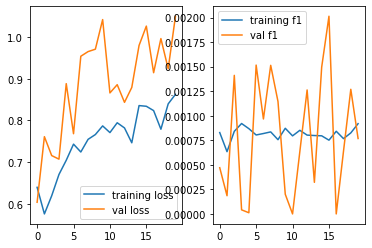

In [211]:
f1 = history.history['macro_f1']
val_f1 = history.history['val_macro_f1']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(loss, label = 'training loss')
plt.plot(val_loss, label = 'val loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1, label = 'training f1')
plt.plot(val_f1, label = 'val f1')
plt.legend()

plt.show()

In [181]:
file = open('./weights.txt', 'w')
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')

file.close()

In [223]:
result = model(X_train[2:3])
# result = tf.nn.sigmoid(result)
print(result)
result = tf.cast(result > 0.5, dtype=tf.int32).numpy()
result = np.nonzero(result)
print(words[0][result[1]])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(
[[ -9.618457    -9.051194     0.1956786  -11.306844    -2.502284
  -12.58729     -8.167072    -4.083183   -16.68796     -1.8373895
  -10.473136    -6.7043543   -8.5410185  -11.998564   -10.504842
   -8.700628    -4.176539   -12.004188   -18.56776    -16.803623
   -9.248833    -6.72508     -6.3826447  -11.451312    -3.235696
  -13.185269    -8.864828    -6.247073    -7.8455133   -7.9555717
   -1.8270142  -12.112698    -3.9657073   -7.8376946  -12.294483
   -8.505979    -3.9385707  -12.229969  

In [61]:
a = np.array([[0, 0],[1, 0]], dtype = np.float32)
b = np.array([[-10, 0],[-3, 1]], dtype = np.float32)
tf.nn.sigmoid_cross_entropy_with_logits(a, b)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[4.5398898e-05, 6.9314718e-01],
       [3.0485873e+00, 1.3132617e+00]], dtype=float32)>

In [52]:
import numpy as np
import tensorflow as tf
 
def sigmoid(x):
    return 1.0/(1+np.exp(-x))
 
labels=np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])
logits=np.array([[11.,8.,7.],[10.,14.,3.],[1.,2.,4.]])
y_pred=sigmoid(logits)
prob_error1=-labels*np.log(y_pred)-(1-labels)*np.log(1-y_pred)
print(prob_error1)
 
print(".............")
labels1=np.array([[0.,1.,0.],[1.,1.,0.],[0.,0.,1.]])#不一定只属于一个类别
logits1=np.array([[1.,8.,7.],[10.,14.,3.],[1.,2.,4.]])
y_pred1=sigmoid(logits1)
prob_error11=-labels1*np.log(y_pred1)-(1-labels1)*np.log(1-y_pred1)
print(prob_error11)
 
print(".............")
print(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels,logits=logits))
print(".............")
print(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels1,logits=logits1))

[[1.67015613e-05 8.00033541e+00 7.00091147e+00]
 [1.00000454e+01 8.31528373e-07 3.04858735e+00]
 [1.31326169e+00 2.12692801e+00 1.81499279e-02]]
.............
[[1.31326169e+00 3.35406373e-04 7.00091147e+00]
 [4.53988992e-05 8.31528373e-07 3.04858735e+00]
 [1.31326169e+00 2.12692801e+00 1.81499279e-02]]
.............
tf.Tensor(
[[1.67015613e-05 8.00033541e+00 7.00091147e+00]
 [1.00000454e+01 8.31528373e-07 3.04858735e+00]
 [1.31326169e+00 2.12692801e+00 1.81499279e-02]], shape=(3, 3), dtype=float64)
.............
tf.Tensor(
[[1.31326169e+00 3.35406373e-04 7.00091147e+00]
 [4.53988992e-05 8.31528373e-07 3.04858735e+00]
 [1.31326169e+00 2.12692801e+00 1.81499279e-02]], shape=(3, 3), dtype=float64)
